# ESM Sample

In [1]:
# Imports
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib import pyplot as plt

In [2]:
#Set up
%matplotlib inline
pandas2ri.activate()

In [3]:
# Paths
pheno_path = '/data1/abide/Pheno/full_merged_pheno.csv' # ABIDE with ADOS_sev
out_path = '/data1/abide/Pheno/psm_pheno.csv' # ABIDE with ADOS_sev

In [4]:
# Get the pheno
pheno = pd.read_csv(pheno_path)
# Kill whitespace
pheno.columns = [x.strip(' ') for x in pheno.columns]
# select the columns that need to go into the PSM
cols = ['SITE_ID', 'SUB_ID', 'AGE_AT_SCAN', 
        'FD', 'FD_scrubbed', 'EYE_STATUS_AT_SCAN',
        'FIQ', 'VIQ', 'PIQ', 'DX_GROUP']
use_pheno = pheno[cols]
use_pheno['DX_GROUP'].replace(to_replace=[2,1], value=[1,0], inplace=True)
# Group the pheno information by site - so we can run PSM individually on each site
group_site = use_pheno.groupby('SITE_ID')

/home/surchs/Venv/serv3/lib/python3.5/site-packages/pandas/core/generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
# Set up the PSM function
def run_psm(pheno):
    '''
    Function that calls the PSM script in R and returns a dataframe 
    that includes a column for matching and keeping
    '''
    categories = ['DX_GROUP']
    # Declare Formula for Mahalanobis distance matching (using the names from CSV)
    ## Format: Disease variable ~  What to Match by 1 + What to Match by 2 + ...
    ## All variables matched by must be NUMERIC
    Mah_formula = 'DX_GROUP ~ FD_scrubbed + AGE_AT_SCAN' 
    # Declare Caliper Width (as a fraction of the SD of the Propensity Scores)
    cal_width = 20
    # Declare Formula for PSM distance matching (using the names from CSV)
    ## Format: Disease variable ~  What to Match by 1 + What to Match by 2 + ...
    PSM_formula = 'DX_GROUP ~ FD_scrubbed + AGE_AT_SCAN'
    
    # Store data in R
    robjects.globalenv["data"] = pandas2ri.py2ri(pheno)
    robjects.globalenv["categories"] = robjects.StrVector(categories)
    robjects.globalenv["Mah_formula"] = Mah_formula
    robjects.globalenv["cal_width"] = cal_width
    robjects.globalenv["PSM_formula"] = PSM_formula
    
    # Run R script
    tmp = robjects.r(
    '''
      # Load R Librarires
      library(optmatch)

      # Make all categories factors
      for (ff in 1:length(categories)) {
        data[[categories[ff]]] <- as.factor(data[[categories[ff]]])
      }

      # Performs Matching
      Matching <- fullmatch(
      match_on( as.formula(Mah_formula),
               data = data ) + 
        caliper( match_on( as.formula(PSM_formula), 
                         data = data ),
                width = cal_width ),
      data = data )

      # Make a data frame with a column with 1 to keep an observation and 0 to leave out
      save_data <- cbind(data,match=Matching)
      save_data$keep <- as.numeric(!is.na(save_data$match))
      save_data$match = as.numeric(as.character(save_data$match))
    ''')
    
    # Get the results back
    data = pandas2ri.ri2py(robjects.r['save_data'])
    
    return data

In [6]:
grp_list = [run_psm(group) for name, group in group_site]

/home/surchs/Venv/serv3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/home/surchs/Venv/serv3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The optmatch package has an academic license. Enter relaxinfo() for more information.

  warnings.warn(x, RRuntimeWarning)


In [7]:
new_pheno = pd.concat(grp_list)

In [8]:
a = grp_list[5]

In [9]:
ctrl = a[a['DX_GROUP'].astype(float)==1]
pati = a[a['DX_GROUP'].astype(float)==0]

In [10]:
a.DX_GROUP.value_counts()

1    105
0     79
Name: DX_GROUP, dtype: int64

In [11]:
ctrl.head()

,SITE_ID,SUB_ID,AGE_AT_SCAN,FD,FD_scrubbed,EYE_STATUS_AT_SCAN,FIQ,VIQ,PIQ,DX_GROUP,match,keep
291,NYU,51036,8.04,0.201879,0.170828,1,101.0,102.0,99.0,1,1.1,1.0
292,NYU,51038,8.26,0.139671,0.132804,1,134.0,143.0,117.0,1,1.2,1.0
293,NYU,51039,8.50,0.152128,0.145173,1,136.0,131.0,133.0,1,1.3,1.0
294,NYU,51040,8.52,0.186761,0.148467,1,129.0,132.0,120.0,1,1.4,1.0
295,NYU,51041,8.90,0.220701,0.213888,1,100.0,100.0,99.0,1,1.5,1.0


In [15]:
cm = ctrl.match.values
pm = pati.match.values

In [18]:
np.argmin(np.abs(pm-cm[0]))

48

In [20]:
pm

array([ 1.48 ,  1.62 ,  1.73 ,  1.56 ,  1.58 ,  1.88 ,  1.56 ,  1.21 ,
        1.102,  1.23 ,  1.25 ,  1.105,  1.3  ,  1.16 ,  1.6  ,  1.6  ,
        1.5  ,  1.83 ,  1.82 ,  1.65 ,  1.29 ,  1.59 ,  1.54 ,  1.61 ,
        1.27 ,  1.32 ,  1.28 ,  1.45 ,  1.6  ,  1.13 ,  1.52 ,  1.17 ,
        1.64 ,  1.4  ,  1.46 ,  1.15 ,  1.2  ,  1.38 ,  1.55 ,  1.51 ,
        1.57 ,  1.14 ,  1.74 ,  1.87 ,  1.4  ,  1.84 ,  1.71 ,  1.12 ,
        1.1  ,  1.42 ,  1.1  ,  1.9  ,  1.35 ,  1.8  ,  1.54 ,  1.5  ,
        1.48 ,  1.5  ,  1.41 ,  1.7  ,  1.24 ,  1.2  ,  1.75 ,  1.94 ,
        1.22 ,  1.8  ,  1.76 ,  1.99 ,  1.31 ,  1.94 ,  1.19 ,  1.3  ,
        1.79 ,  1.26 ,  1.5  ,  1.43 ,  1.5  ,  1.47 ,  1.11 ])

In [19]:
pm[48]

1.1000000000000001

In [50]:
pati.iloc[0].SUB_ID

50952

In [54]:
pati[pati.SUB_ID==50952].index.tolist()

['212']

In [56]:
pati.loc['212'].SUB_ID

50952

In [37]:
pati[pati['SUB_ID']==50982]

,SITE_ID,SUB_ID,AGE_AT_SCAN,FD,FD_scrubbed,EYE_STATUS_AT_SCAN,FIQ,VIQ,PIQ,DX_GROUP,match,keep
241,NYU,50982,9.46,0.11084,0.106204,1,119.0,121.0,106.0,0,1.13,1.0


In [58]:
patIDs = pati.SUB_ID.tolist()
ctrIDs = ctrl.SUB_ID.tolist()

In [59]:
pat_match = pati.match.tolist()
ctr_match = ctrl.match.tolist()

In [ ]:
# Sort the IDs based on the match score


In [65]:
for (x,y) in sorted(zip(pat_match, patIDs)):
    print('{} and {}'.format(x,y))

1.1 and 51001
1.1 and 51003
1.102 and 50960
1.105 and 50964
1.11 and 51035
1.12 and 51000
1.13 and 50982
1.14 and 50994
1.15 and 50988
1.16 and 50966
1.17 and 50984
1.19 and 51026
1.2 and 50989
1.2 and 51016
1.21 and 50959
1.22 and 51019
1.23 and 50961
1.24 and 51015
1.25 and 50962
1.26 and 51029
1.27 and 50977
1.28 and 50979
1.29 and 50973
1.3 and 50965
1.3 and 51027
1.31 and 51024
1.32 and 50978
1.35 and 51007
1.38 and 50990
1.4 and 50986
1.4 and 50997
1.41 and 51013
1.42 and 51002
1.43 and 51032
1.45 and 50980
1.46 and 50987
1.47 and 51034
1.48 and 50952
1.48 and 51011
1.5 and 50969
1.5 and 51010
1.5 and 51012
1.5 and 51030
1.5 and 51033
1.51 and 50992
1.52 and 50983
1.54 and 50975
1.54 and 51009
1.55 and 50991
1.56 and 50955
1.56 and 50958
1.57 and 50993
1.58 and 50956
1.59 and 50974
1.6 and 50967
1.6 and 50968
1.6 and 50981
1.61 and 50976
1.62 and 50953
1.64 and 50985
1.65 and 50972
1.7 and 51014
1.71 and 50999
1.73 and 50954
1.74 and 50995
1.75 and 51017
1.76 and 51021
1.79 and 5

In [32]:
for index, row in ctrl.iterrows():
    cmr = row.match
    # Find match
    match = np.argmin(np.abs(np.array(pat_match)-cmr))
    
    
    
    
    print('best match for {} ({}) is {} ({})'.format(ctrl.loc[index].SUB_ID, 
                                                     cmr, pati.iloc[match].SUB_ID,
                                                     pati.iloc[match].match))

best match for 51036 (1.1) is 51001 (1.1)
best match for 51038 (1.2) is 50989 (1.2)
best match for 51039 (1.3) is 50965 (1.3)
best match for 51040 (1.4) is 50986 (1.4)
best match for 51041 (1.5) is 50969 (1.5)
best match for 51042 (1.6) is 50967 (1.6)
best match for 51044 (1.7) is 51014 (1.7)
best match for 51045 (1.8) is 51008 (1.8)
best match for 51046 (1.9) is 51006 (1.9)
best match for 51047 (1.1) is 51001 (1.1)
best match for 51048 (1.11) is 51035 (1.11)
best match for 51049 (1.12) is 51000 (1.12)
best match for 51050 (1.13) is 50982 (1.13)
best match for 51051 (1.14) is 50994 (1.14)
best match for 51052 (1.15) is 50988 (1.15)
best match for 51053 (1.16) is 50966 (1.16)
best match for 51054 (1.17) is 50984 (1.17)
best match for 51055 (1.16) is 50966 (1.16)
best match for 51056 (1.19) is 51026 (1.19)
best match for 51057 (1.2) is 50989 (1.2)
best match for 51058 (1.21) is 50959 (1.21)
best match for 51059 (1.22) is 51019 (1.22)
best match for 51060 (1.23) is 50961 (1.23)
best match

In [ ]:
aaa

In [8]:
new_pheno

,SITE_ID,SUB_ID,AGE_AT_SCAN,FD,FD_scrubbed,EYE_STATUS_AT_SCAN,FIQ,VIQ,PIQ,DX_GROUP,match,keep
0,CALTECH,51456,55.4000,0.434593,0.328121,2,126.0,118.0,128.0,0,1.10,1.0
1,CALTECH,51457,22.9000,0.207160,0.170893,2,107.0,119.0,93.0,0,1.10,1.0
2,CALTECH,51458,39.2000,0.322805,0.288872,2,93.0,80.0,108.0,0,1.10,1.0
3,CALTECH,51459,22.8000,0.152963,0.152963,2,106.0,94.0,118.0,0,1.12,1.0
4,CALTECH,51460,34.6000,0.207277,0.207277,2,133.0,135.0,122.0,0,1.20,1.0
5,CALTECH,51461,37.7000,0.391293,0.288861,2,99.0,111.0,84.0,0,1.15,1.0
6,CALTECH,51462,20.2000,0.289176,0.259051,2,107.0,102.0,110.0,0,1.14,1.0
7,CALTECH,51463,20.2000,0.150294,0.142741,2,102.0,101.0,103.0,0,1.60,1.0
8,CALTECH,51464,20.9000,0.149419,0.149419,2,101.0,118.0,109.0,0,1.80,1.0
9,CALTECH,51465,20.2000,0.171973,0.171973,2,96.0,99.0,93.0,0,1.90,1.0


In [11]:
psm_pheno = new_pheno[new_pheno['keep']==1]

In [12]:
grp_site = psm_pheno.groupby('SITE_ID')

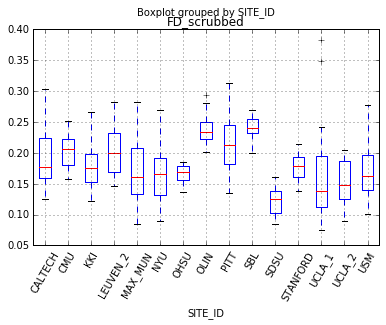

In [23]:
new_pheno.boxplot('FD_scrubbed', by='SITE_ID', rot=60)

In [15]:
old_list = [(name, group) for name, group in group_site]
new_list = [(name, group) for name, group in grp_site]

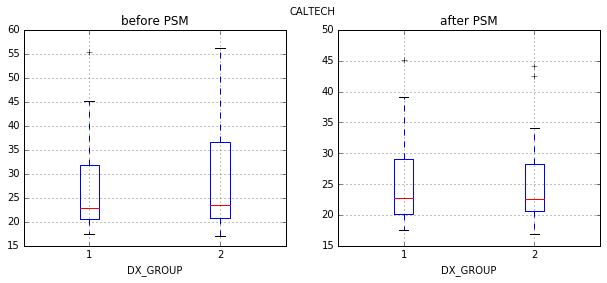

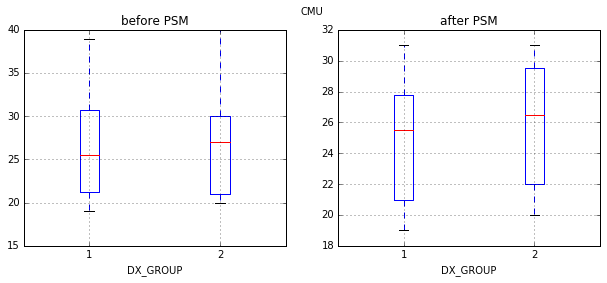

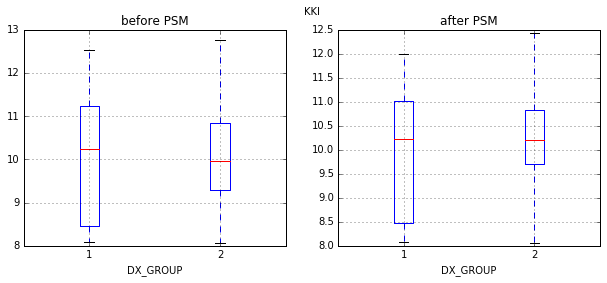

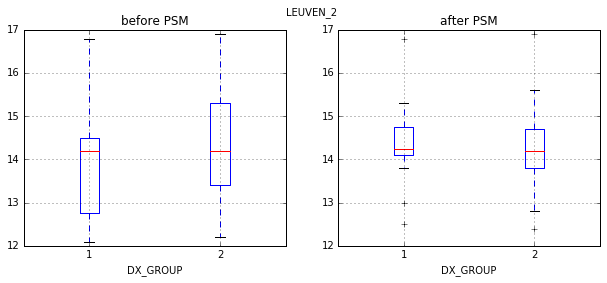

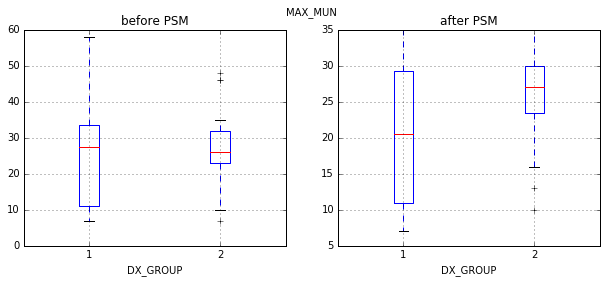

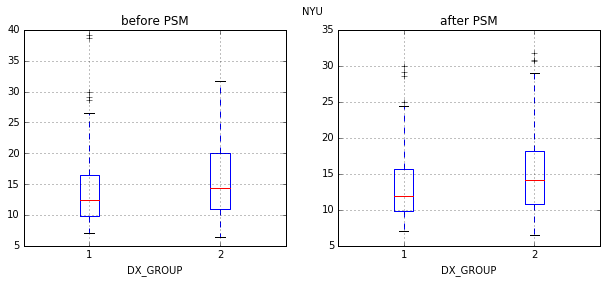

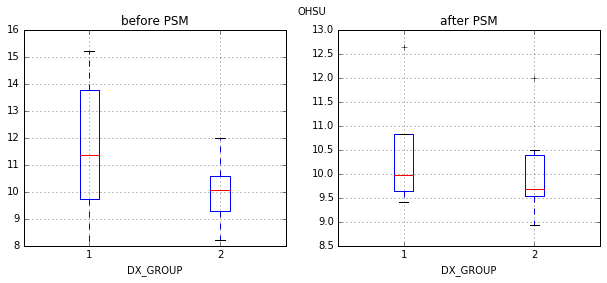

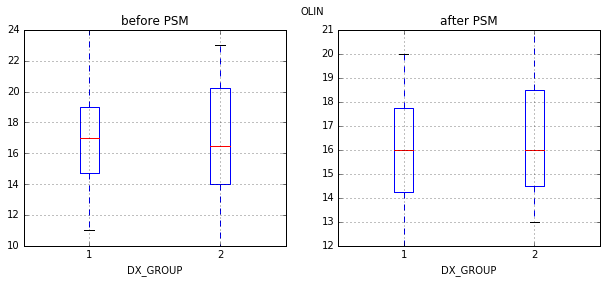

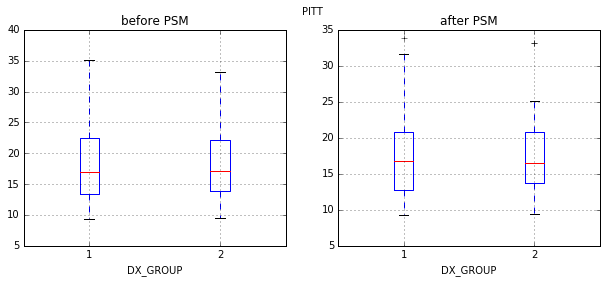

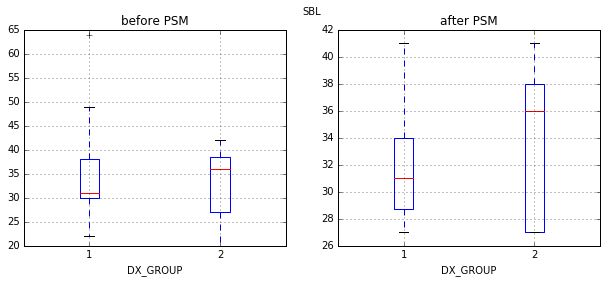

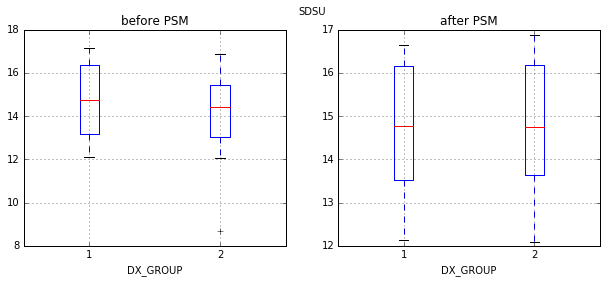

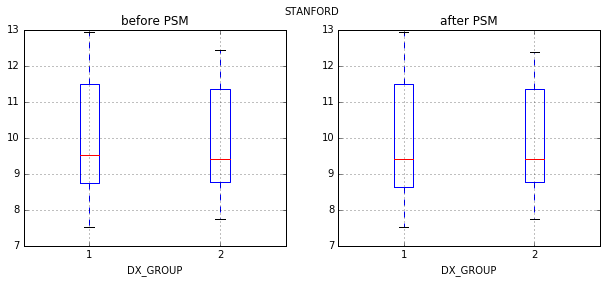

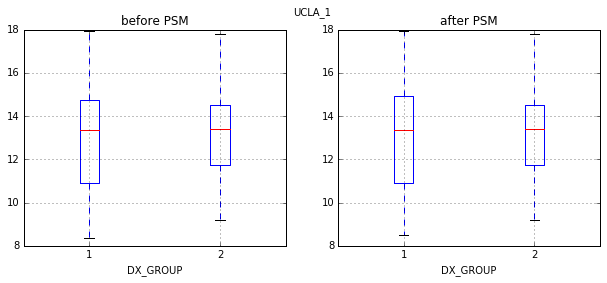

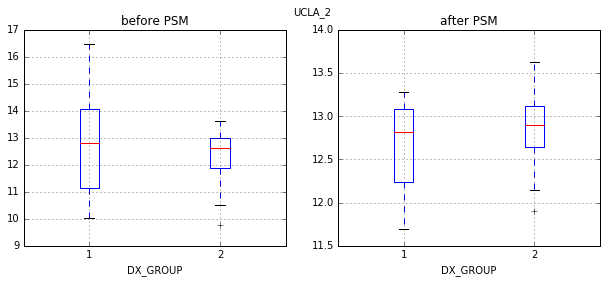

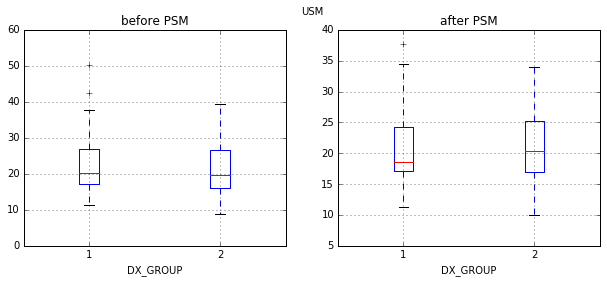

In [21]:
for gid, olditem in enumerate(old_list):
    newitem = new_list[gid]
    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    olditem[1].boxplot('AGE_AT_SCAN', by='DX_GROUP', ax=ax1)
    newitem[1].boxplot('AGE_AT_SCAN', by='DX_GROUP', ax=ax2)
    f.suptitle(olditem[0])
    ax1.set_title('before PSM')
    ax2.set_title('after PSM')

In [26]:
a = olditem[1]

In [30]:
a.groupby('DX_GROUP')['DX_GROUP'].count().plot(kind='bar')

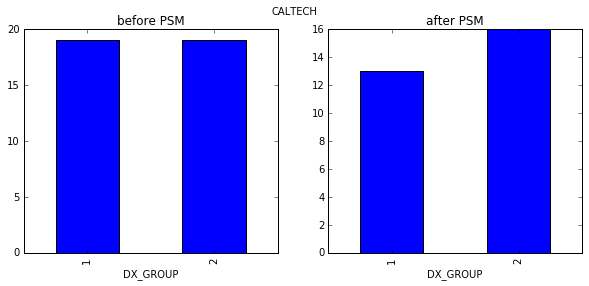

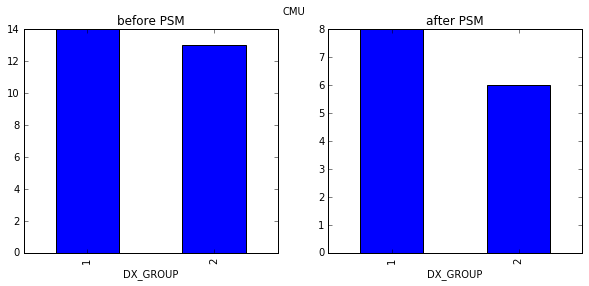

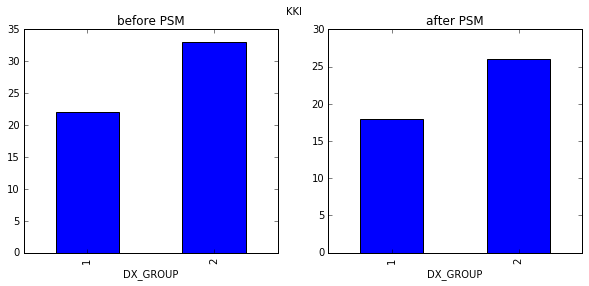

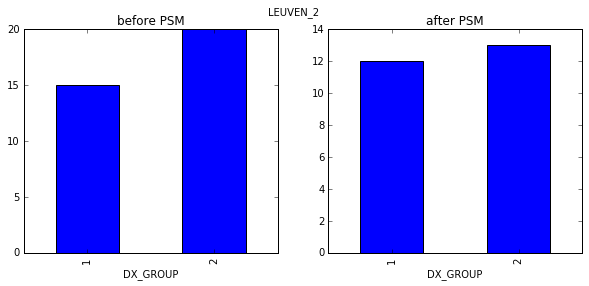

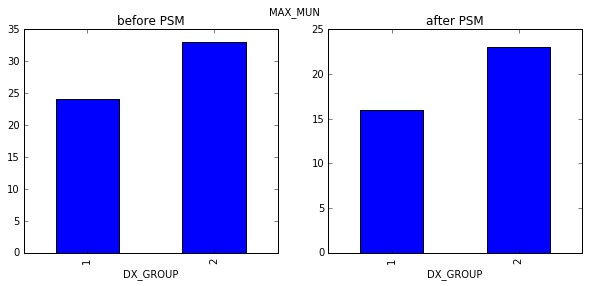

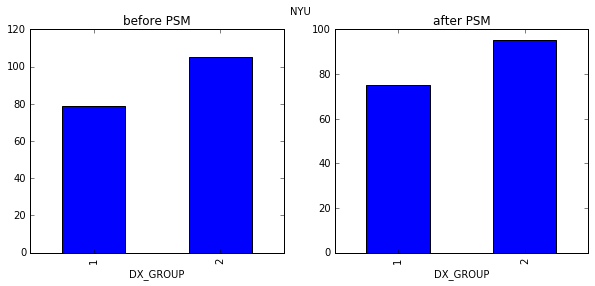

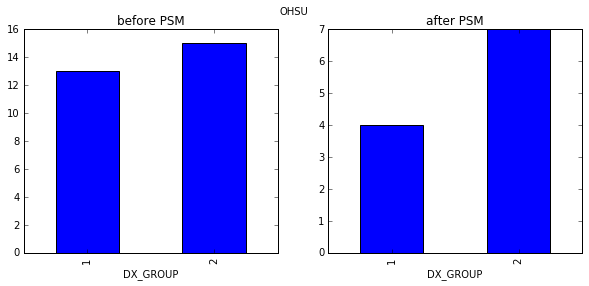

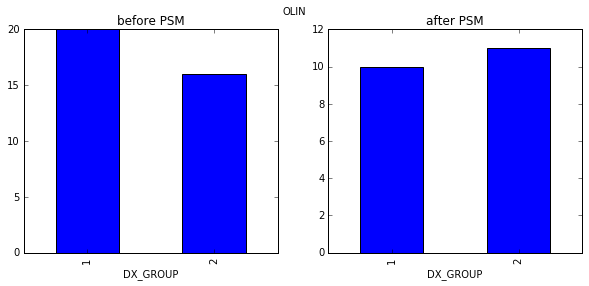

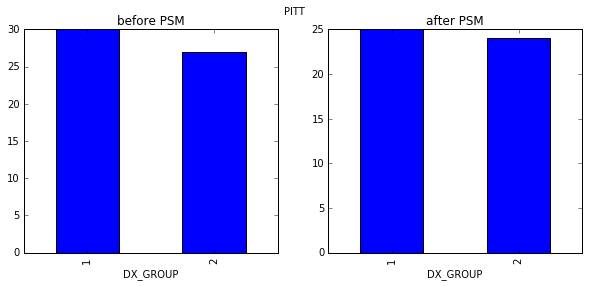

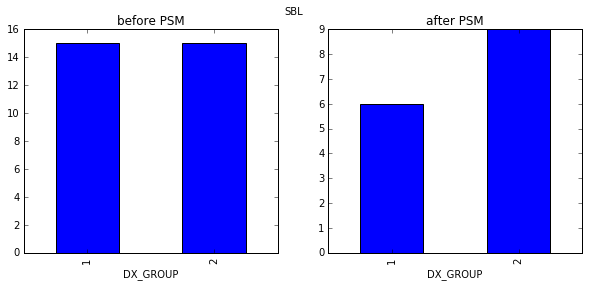

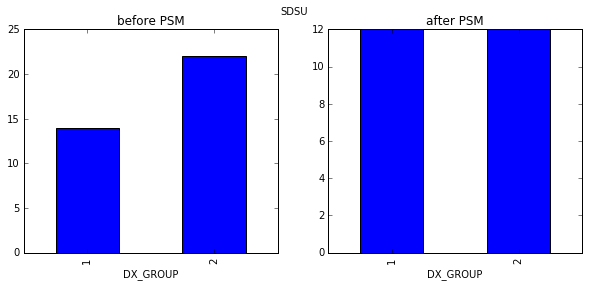

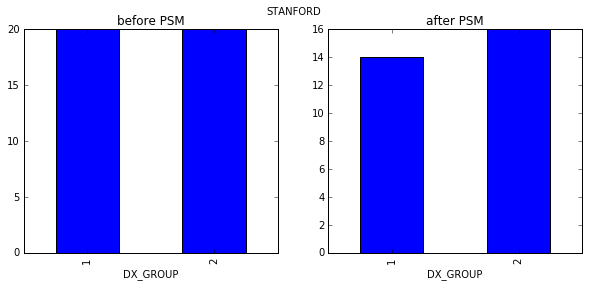

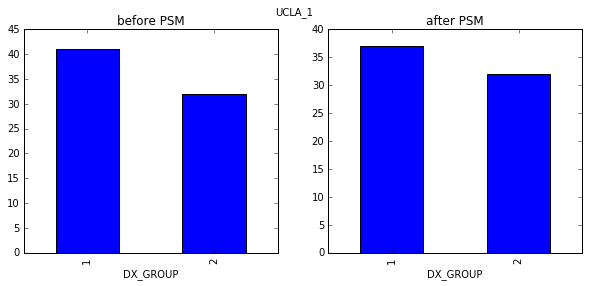

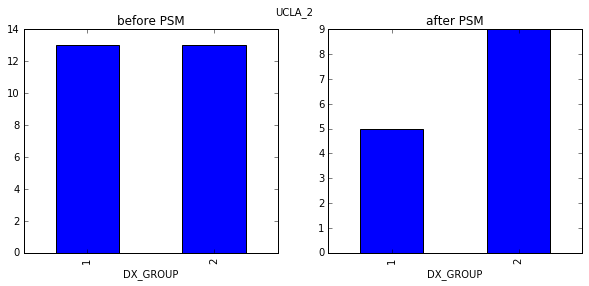

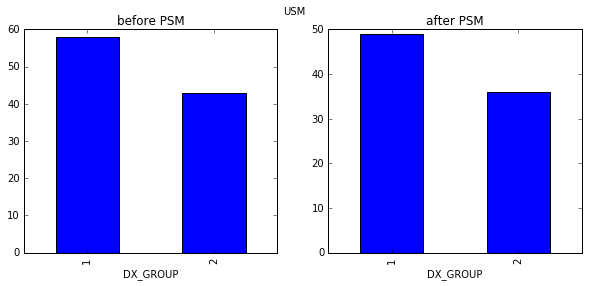

In [34]:
for gid, olditem in enumerate(old_list):
    newitem = new_list[gid]
    f = plt.figure(figsize=(10,4))
    
    ax1 = f.add_subplot(121)
    olditem[1].groupby('DX_GROUP')['DX_GROUP'].count().plot(kind='bar')
    ax1.set_title('before PSM')
    
    ax2 = f.add_subplot(122)
    newitem[1].groupby('DX_GROUP')['DX_GROUP'].count().plot(kind='bar')
    ax2.set_title('after PSM')
    
    f.suptitle(olditem[0])

In [13]:
# Go by match score and see what happens
nyu_match = psm_pheno[psm_pheno['SITE_ID']=='NYU']

In [25]:
nyu_match['DX_GROUP'].value_counts()

2    105
1     79
Name: DX_GROUP, dtype: int64

In [40]:
# Get the patient and control IDs and their propensity scores
control_list = [(row['SUBJECT_ID'], row['match']) for index, row in nyu_match[nyu_match['DX_GROUP']==True].iterrows()]

In [41]:
control_list

[]